## Производительность индексов

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

## Графики до и после добавления индексов
Для задачи было сгенерировано 1000000 анкет для социальной сети и добавлена ручка с параметрами firstname, secondname. <br>
Для тестирования использован инструмент wrk. <br>
Тестирование проводилось на MacBook Pro (15-inch, 2019), бд, приложение и нагрузка запускались локально. <br>
Тестирование проводилось на запросе вида firstName LIKE ? and secondName LIKE ? + cортировка вывода по id анкеты. <br>
Результаты тестирования на графиках ниже.

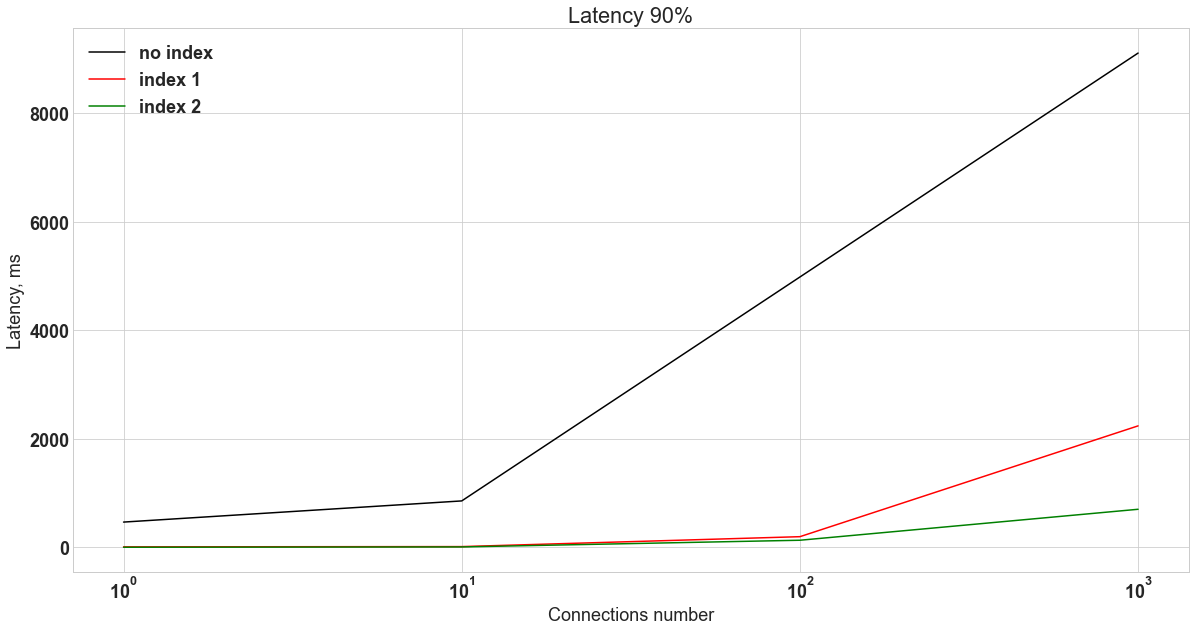

In [2]:
# latency 90
x = [1, 10, 100, 1000]
x1 = [1, 10, 1000]
y_no = [467, 857, 9110]
y_i1 = [10.5, 15.3, 198, 2240]
y_i2 =  [3.27, 8.94, 132.3, 703]

font = {'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
plt.rcParams["figure.figsize"] = (20,10)

plt.semilogx(x1, y_no, '-', color='black', label='no index')
plt.semilogx(x, y_i1, '-', color='red', label='index 1')
plt.semilogx(x, y_i2, '-', color='green', label='index 2')

plt.title('Latency 90%')
plt.xlabel('Connections number')
plt.ylabel('Latency, ms')
plt.legend()

#### примечание
* для 1000 соединений без индекса: <br>
0 requests in 5.00m, 0.00B read <br>
Socket errors: connect 0, read 3980, write 16, timeout 0 <br>
* для 1000 соединений с двумя индексами (index 1): <br>
110909 requests in 1.67m, 24.33MB read<br>
Socket errors: connect 0, read 1353, write 32, timeout 0 <br>

сырые данные лежат в report_raw_data.txt

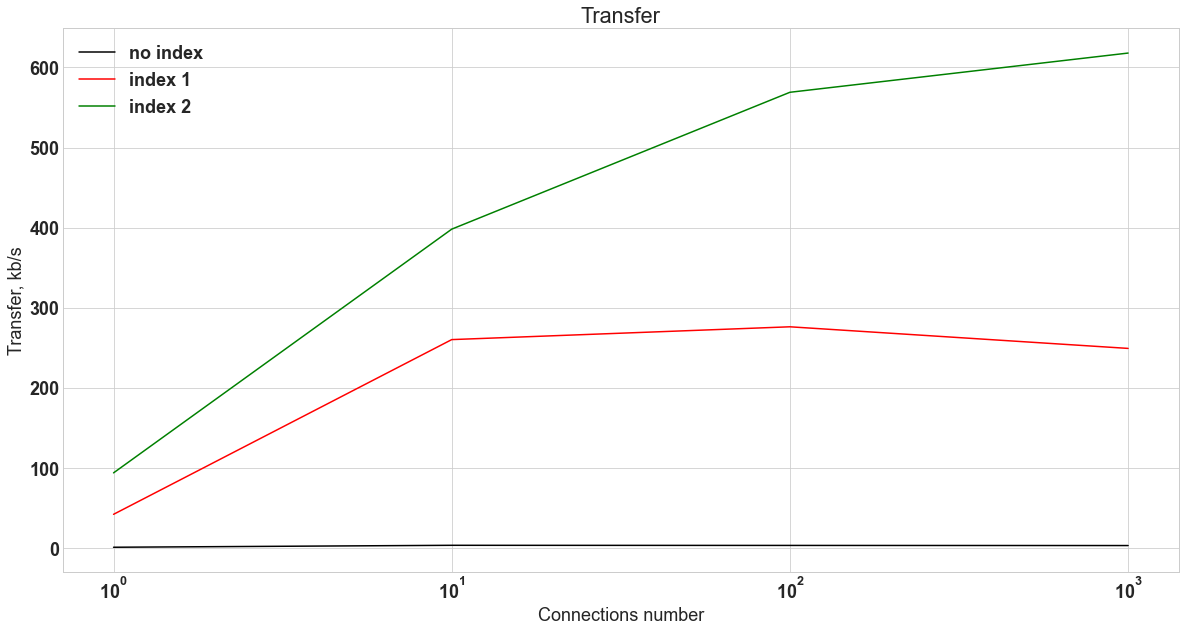

In [3]:
# KB/s
x = [1, 10, 100, 1000]
x1 = [1, 10, 1000]

y_no = [0.57, 3, 2.69]
y_i1 = [41.7, 260, 276, 249]
y_i2 =  [93.5, 398, 569, 618]

font = {'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
plt.rcParams["figure.figsize"] = (20,10)


plt.semilogx(x1, y_no, '-', color='black', label='no index')
plt.semilogx(x, y_i1, '-', color='red', label='index 1')
plt.semilogx(x, y_i2, '-', color='green', label='index 2')

plt.title('Transfer')
plt.xlabel('Connections number')
plt.ylabel('Transfer, kb/s')
plt.legend()

index 1 - было построено 2 индекса: на first_name и second_name <br>
```sql
create index users_first_name_index
    on users (first_name);
create index users_second_name_index
    on users (second_name);
```
index 2 - построен индекс (first_name, second_name)

```sql
create index users_first_name_second_name_index
    on users (first_name, second_name);
```
для данного запроса второй вариант показывает лучшую производительность, тк используется 1 индексу

план запроса для индекса (first_name, second_name)
```json
{
  "query_block": {
    "select_id": 1,
    "cost_info": {
      "query_cost": "3.41"
    },
    "ordering_operation": {
      "using_filesort": true,
      "cost_info": {
        "sort_cost": "1.00"
      },
      "table": {
        "table_name": "users",
        "access_type": "range",
        "possible_keys": [
          "users_first_name_second_name_index"
        ],
        "key": "users_first_name_second_name_index",
        "used_key_parts": [
          "first_name",
          "second_name"
        ],
        "key_length": "104",
        "rows_examined_per_scan": 1,
        "rows_produced_per_join": 1,
        "filtered": "100.00",
        "index_condition": "((`db`.`users`.`first_name` like 'Bobby') and (`db`.`users`.`second_name` like 'Chase'))",
        "cost_info": {
          "read_cost": "2.21",
          "eval_cost": "0.20",
          "prefix_cost": "2.41",
          "data_read_per_join": "1K"
        },
        "used_columns": [
          "id",
          "username",
          "first_name",
          "second_name"
        ]
      }
    }
  }
}

```